In [1]:
import copy
import os
import collections

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline
import pymatgen.ext.matproj
import functools
import swifter

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
import DigitalEcosystem.utils.misc
import DigitalEcosystem.utils.functional
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import  noble_gases, f_block_elements, synthetic_elements_in_d_block

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
data_path = "../matproj_parent_eAboveHull/data_with_mp_ids.csv"
data = pd.read_csv(data_path, index_col=0).fillna(0)

In [4]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))

@DigitalEcosystem.utils.functional.except_with_default_value()
def e_above_hull_fuan(matproj_id):
    return DigitalEcosystem.utils.misc.get_e_above_hull(matproj_id, pymatgen_rester=rester)

def e_cohesive_fun(matproj_id, pymatgen_rester=rester):
    return pymatgen_rester.get_cohesive_energy(matproj_id, per_atom=True)

@DigitalEcosystem.utils.functional.except_with_default_value()
def lookup_with_api(matproj_id, pymatgen_rester=rester, prop=''):
    return pymatgen_rester.get_data(matproj_id, prop=prop)[0][prop]

df = data[data['mp_id (unitless)'] != 'no_parent']
for prop in ('energy_per_atom', 'volume', 'formation_energy_per_atom', 'band_gap', 'density'):
    df[f'mp_{prop}'] = df['mp_id (unitless)'].swifter.progress_bar(enable=True, desc=prop).apply(functools.partial(lookup_with_api, prop=prop))


energy_per_atom:   0%|          | 0/2579 [00:00<?, ?it/s]

volume:   0%|          | 0/2579 [00:00<?, ?it/s]

formation_energy_per_atom:   0%|          | 0/2579 [00:00<?, ?it/s]

band_gap:   0%|          | 0/2579 [00:00<?, ?it/s]

density:   0%|          | 0/2579 [00:00<?, ?it/s]

In [5]:
target = ['bandgap (eV)']
reg_cols = [col for col in df.columns if col.startswith("mp") and "unitless" not in col]
reg_cols += ['max:atomic_number', 'min:atomic_number', 'ave:atomic_number', 'e_above_hull', 'ave:num_p_unfilled', *matminer_descriptors]
reg_cols += [col for col in df.columns if ":" in col]


x_reg_cols = [col for col in reg_cols if col not in target]

In [6]:
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block

element_mask = df['formula'].apply(lambda string: all([forbidden not in string for forbidden in bad_elements]))

decomposition_mask = df['decomposition_energy (eV/atom)'] < 0.5

exfol_mask = df['exfoliation_energy_per_atom (eV/atom)'] > 0

hull_mask = df['e_above_hull'] <= 0.05


reasonable = df[element_mask & decomposition_mask & exfol_mask & hull_mask].dropna()

train, test = sklearn.model_selection.train_test_split(reasonable[reg_cols + target], test_size=0.1, random_state=RANDOM_SEED)

In [7]:
train_x_regression = np.nan_to_num(train[reg_cols].to_numpy())
train_y_regression = np.nan_to_num(train[target].to_numpy())

test_x_regression = np.nan_to_num(test[reg_cols].to_numpy())
test_y_regression = np.nan_to_num(test[target].to_numpy())

In [8]:
current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_regression

    params = {

    }

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 100),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:pseudohubererror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_regression, objective_validation_y_regression]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 40,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return np.sqrt(score)

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=200),
    direction='minimize'
)

regression_study.optimize(func=objective, n_trials=1024, callbacks=[keep_best_regression])

[I 2021-09-23 10:56:06,404] A new study created in memory with name: no-name-63e6382f-4cbf-48a9-bc82-91a23ab74eb3
[I 2021-09-23 10:56:06,568] Trial 0 finished with value: 0.8987925511412977 and parameters: {'max_depth': 20, 'min_child_weight': 62.21087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.8987925511412977.
[I 2021-09-23 10:56:06,790] Trial 1 finished with value: 0.6291660923604118 and parameters: {'max_depth': 78, 'min_child_weight': 27.25926052826416, 'alpha': 1.3823212757154835, 'lambda': 4.009360887675096}. Best is trial 1 with value: 0.6291660923604118.
[I 2021-09-23 10:56:06,921] Trial 2 finished with value: 0.7369578007726713 and parameters: {'max_depth': 96, 'min_child_weight': 87.59326347420946, 'alpha': 1.7890863497893332, 'lambda': 2.5049756276172936}. Best is trial 1 with value: 0.6291660923604118.
[I 2021-09-23 10:56:07,074] Trial 3 finished with value: 0.9457762302394817 and parameters: {'max_depth': 69, 'min_ch

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


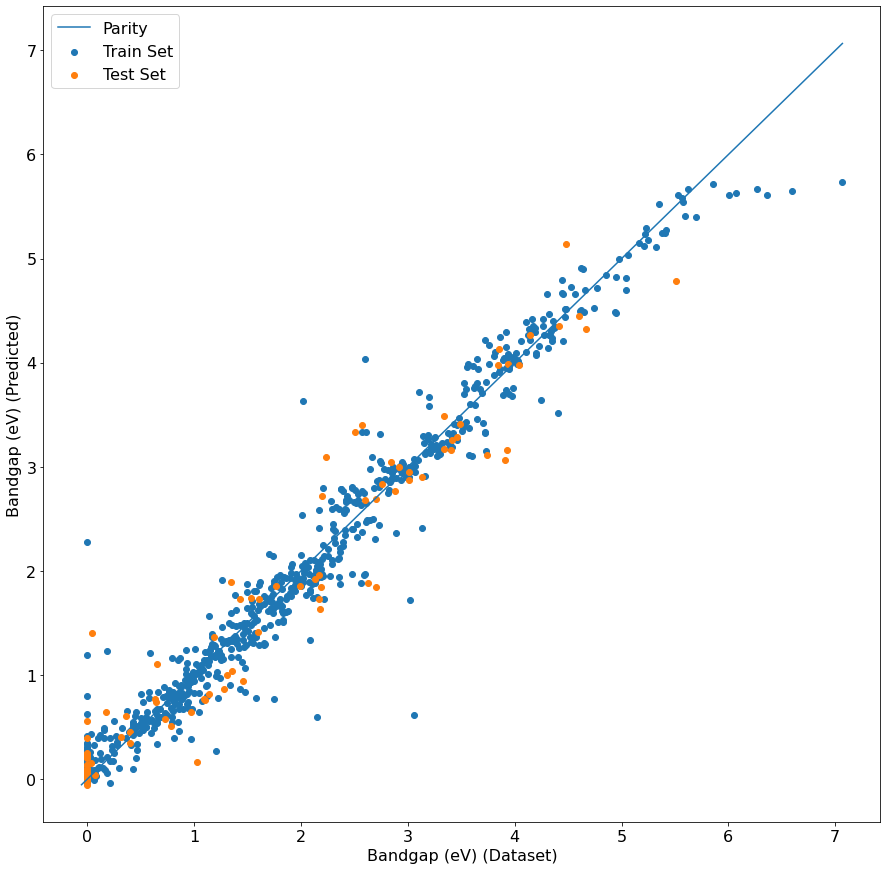

In [9]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                "Bandgap (eV)",
                                                "parity.jpeg")

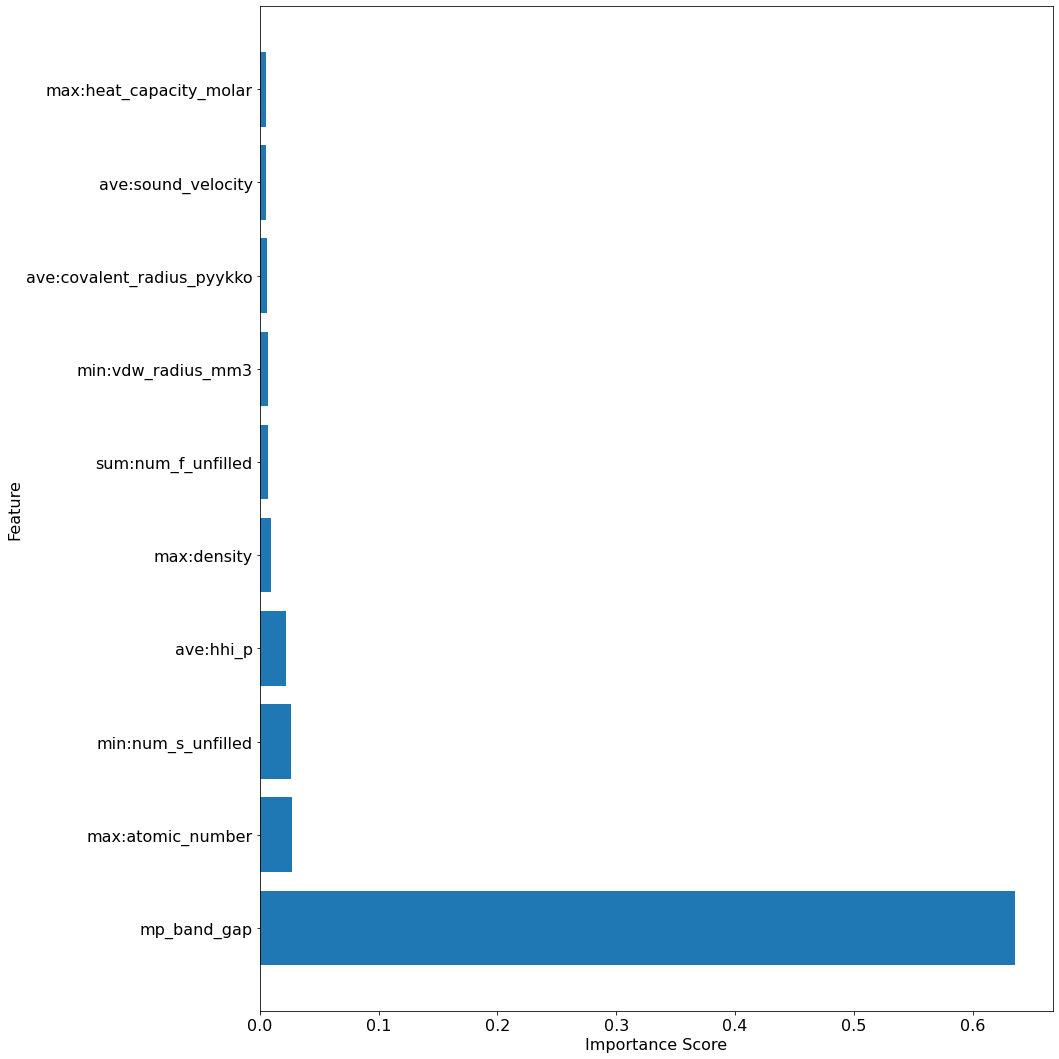

In [10]:
n_importances = 10
importances = list(zip(best_regression[1].feature_importances_, reg_cols))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
print("Test-Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

Test-Set Error Metrics
MaxError 1.362
MAE 0.268
MSE 0.141
RMSE 0.376
MAPE 116899305873293.84
R2 0.94


In [17]:
cols_for_sisso = [i[1] for i in sorted_importances][:10] + ['bandgap (eV)']
train[cols_for_sisso].to_csv('bandgap_sisso_train.csv', index=False)
test[cols_for_sisso].to_csv('bandgap_sisso_test.csv', index=False)

# SISSO

In [128]:
models = {
    'r1_1term': lambda df: 6.305762604497209e+00 + \
                           -3.899085295793941e-02 * (df['ave:covalent_radius_pyykko'] + df['max:density']),
    'r1_2term': lambda df: 8.013812787771061e+00 + \
                          -9.856136741665386e+00 * (df['max:density']/ df['max:atomic_number']) + \
                          -4.173866344605599e-02 * (df['ave:covalent_radius_pyykko'] + df['min:num_s_unfilled']),
    'r1_3term': lambda df: 7.317334564152490e+00 + \
                           -3.195459845706383e-02 * (df['ave:sound_velocity'] + df['ave:covalent_radius_pyykko']) + \
                           3.178134288848232e-02 * (df['ave:sound_velocity'] + df['max:atomic_number']) + \
                           -1.615509850281063e+00 * np.log(df['max:density']),
    'r1_4term': lambda df: 7.113099244960149e+00 + \
                           5.027360011987392e-01 * (df['max:heat_capacity_molar'] / df['max:atomic_number']) + \
                           3.019208238405184e-01 * np.cos(df['max:atomic_number']) + \
                           -1.082904529220121e+01 * (df['max:density'] / df['max:atomic_number']) + \
                           -3.885564807924378e-02 * (df['ave:covalent_radius_pyykko'] - df['max:density']),
    'r2_1term': lambda df: 6.622653406270025e+00 + \
                           -3.673916686305851e-02 * ((df['ave:covalent_radius_pyykko'] * df['max:atomic_number'])/(abs(df['max:density'] - df['max:atomic_number']))),
    'r2_2term': lambda df: 1.555893513782959e+01 + \
                           -7.238797327296671e+00 * abs(np.exp(-1*df['max:density']) - (df['max:density'] / df['max:atomic_number'])) + \
                           -2.550627271537310e+00 * ((df['max:density']/df['max:atomic_number']) + np.cbrt(df['ave:covalent_radius_pyykko'])),
    'r2_3term': lambda df: 1.374001579668306e+01 + \
                           8.417729142423260e+00 * (np.cos(df['min:vdw_radius_mm3']) / (df['max:density']**2)) + \
                           -7.080969005797322e+00 * abs(np.exp(-1 * df['max:density']) - (df['max:density']/df['max:atomic_number'])) + \
                           -2.200729808742001e+00 * ((df['max:density'] / df['max:atomic_number']) + np.cbrt(df['ave:covalent_radius_pyykko'])),
    'r2_4term': lambda df: 1.042522765313325e+01 + \
                           -6.900851096642938e-01 * (np.cos(df['max:atomic_number']) + np.sqrt(df['max:heat_capacity_molar'])) + \
                           -9.754701757588259e-01 * abs(np.cos(df['max:atomic_number']) - (df['ave:covalent_radius_pyykko'] / df['max:heat_capacity_molar'])) + \
                           1.862846679815186e+01 * (np.cos(df['min:vdw_radius_mm3']) / np.exp(df['max:density'])) + \
                           -7.785046263957102e+00 * abs(np.exp(-1 * df['max:density']) - (df['max:density'] / df['max:atomic_number']))
}

for key, fun in models.items():
    train[key] = fun(train)
    test[key] = fun(test)

In [152]:
target='bandgap (eV)'
train_min = min(train['bandgap (eV)'].min(), best_regression.predict(train_x_regression).min())
train_max = max(train['bandgap (eV)'].min(), best_regression.predict(train_x_regression).max())
test_min = min(test['bandgap (eV)'].min(), best_regression.predict(test_x_regression).min())
test_max = max(test['bandgap (eV)'].min(), best_regression.predict(test_x_regression).max())

for key in models.keys():
    train_min = min(train_min, train[key].min())
    train_max = max(train_max, train[key].max())
    test_min = min(test_min, test[key].min())
    test_max = max(test_max, test[key].max())

def get_r2(label, dataset):
    r2 = sklearn.metrics.r2_score(y_true=dataset[target], y_pred=dataset[label])
    return np.round(r2, 2)

In [173]:
plt.rcParams['figure.figsize'] = (7,7)
plt.rcParams['font.size'] = 8

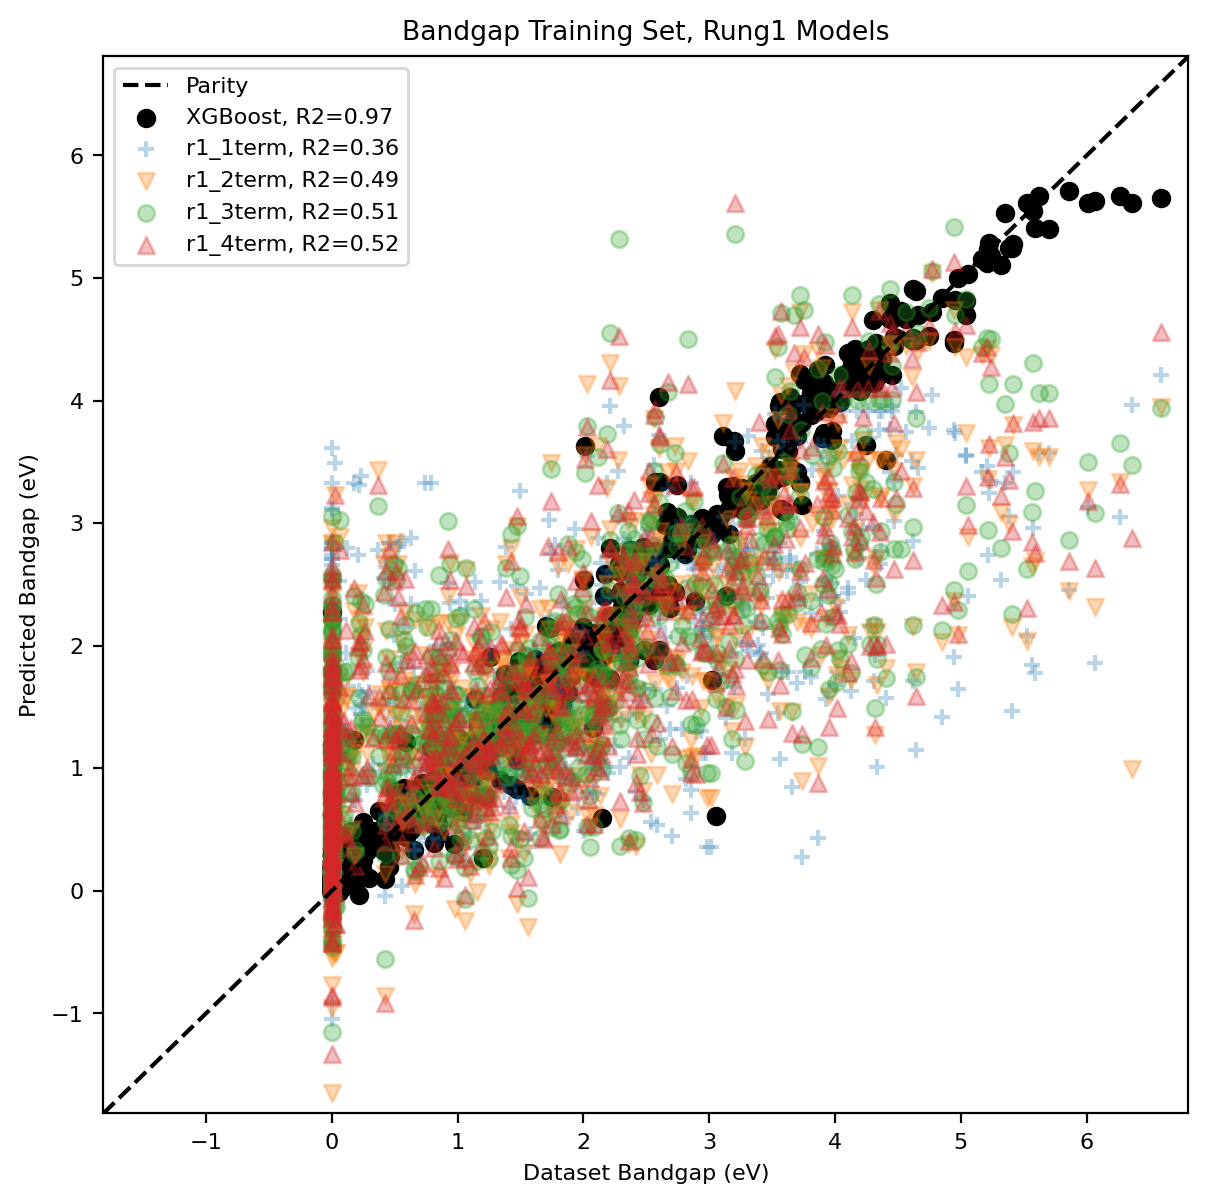

In [174]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=train[target], y_pred=best_regression.predict(train_x_regression)), 2)

plt.scatter(x=train['bandgap (eV)'], y=best_regression.predict(train_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r1_1term', 'r1_2term', 'r1_3term', 'r1_4term']:
    plt.scatter(x=train['bandgap (eV)'], y=train[model_label], label=f"{model_label}, R2={get_r2(model_label, train)}", alpha=0.3, marker=next(markers))
plt.plot([train_min, train_max], [train_min, train_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([train_min, train_max])
plt.ylim([train_min, train_max])

plt.title('Bandgap Training Set, Rung1 Models')
plt.ylabel('Predicted Bandgap (eV)')
plt.xlabel('Dataset Bandgap (eV)')
plt.legend()

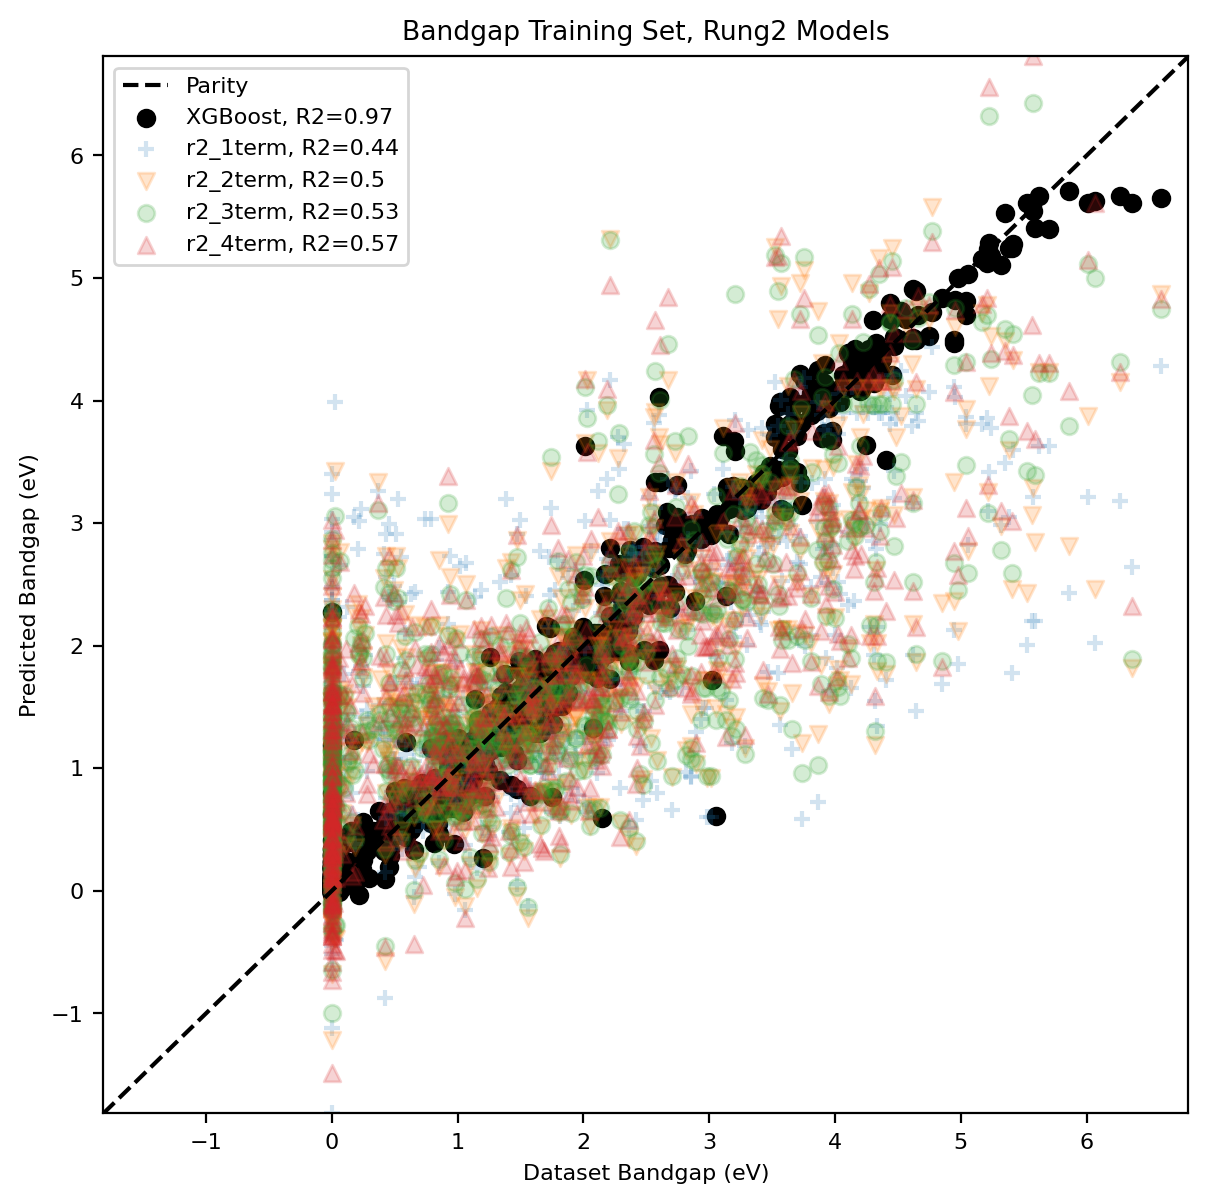

In [176]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=train[target], y_pred=best_regression.predict(train_x_regression)), 2)

plt.scatter(x=train['bandgap (eV)'], y=best_regression.predict(train_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r2_1term', 'r2_2term', 'r2_3term', 'r2_4term']:
    plt.scatter(x=train['bandgap (eV)'], y=train[model_label], label=f"{model_label}, R2={get_r2(model_label, train)}", alpha=0.2, marker=next(markers))
plt.plot([train_min, train_max], [train_min, train_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([train_min, train_max])
plt.ylim([train_min, train_max])
    
plt.title('Bandgap Training Set, Rung2 Models')
plt.ylabel('Predicted Bandgap (eV)')
plt.xlabel('Dataset Bandgap (eV)')
plt.legend()

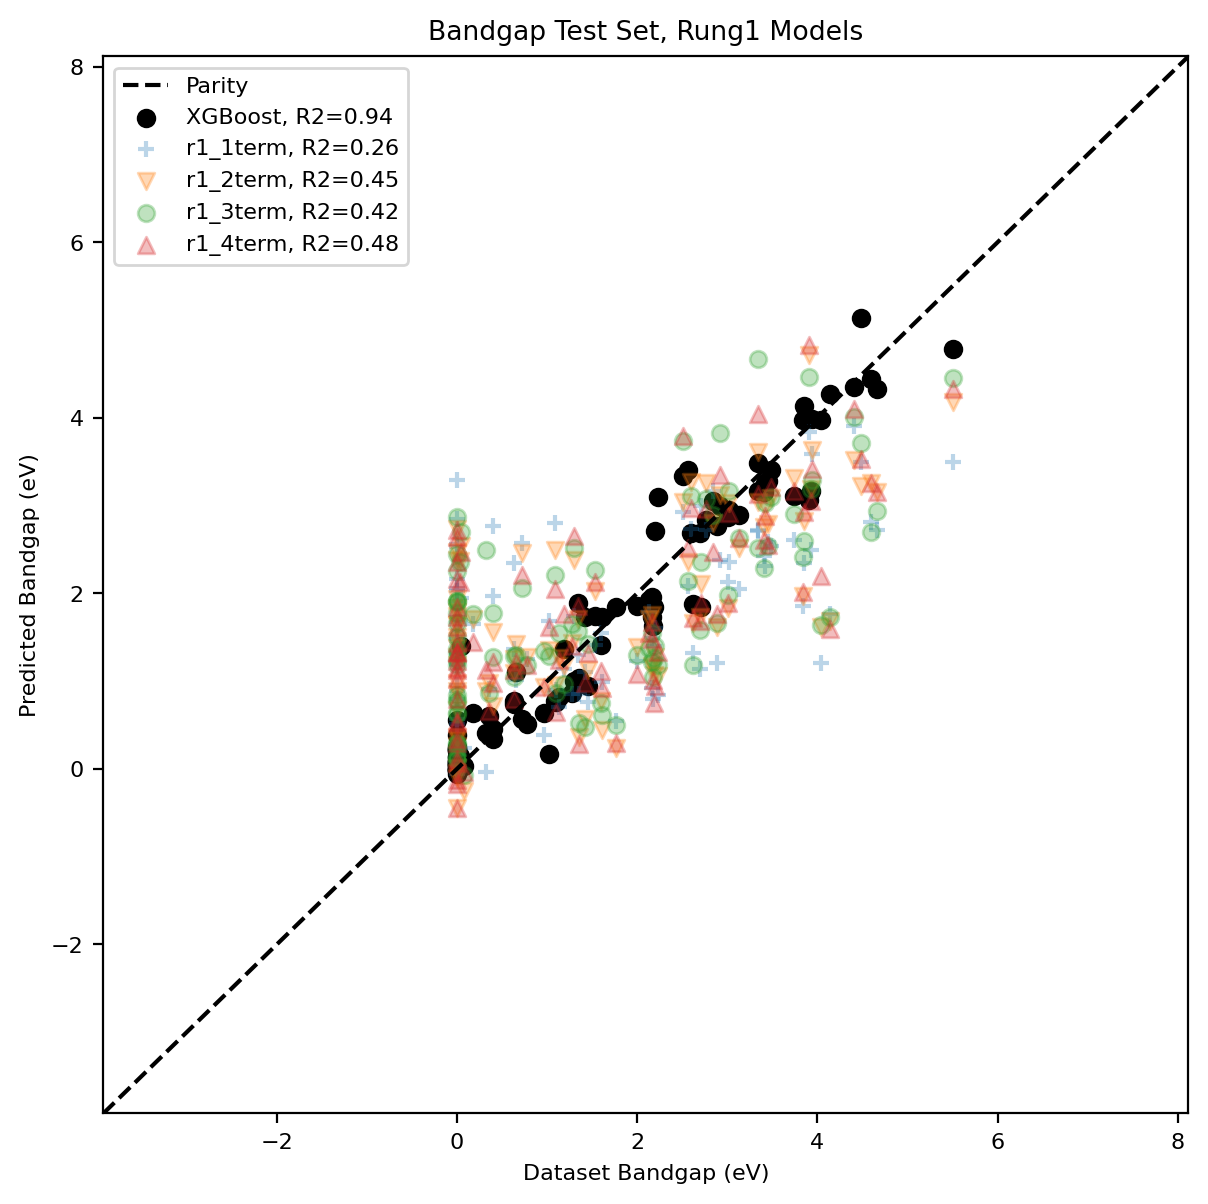

In [177]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=test[target], y_pred=best_regression.predict(test_x_regression)), 2)

plt.scatter(x=test['bandgap (eV)'], y=best_regression.predict(test_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r1_1term', 'r1_2term', 'r1_3term', 'r1_4term']:
    plt.scatter(x=test['bandgap (eV)'], y=test[model_label], label=f"{model_label}, R2={get_r2(model_label, test)}", alpha=0.3, marker=next(markers))
    
plt.plot([test_min, test_max], [test_min, test_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([test_min, test_max])
plt.ylim([test_min, test_max])

plt.title('Bandgap Test Set, Rung1 Models')
plt.ylabel('Predicted Bandgap (eV)')
plt.xlabel('Dataset Bandgap (eV)')
plt.legend()

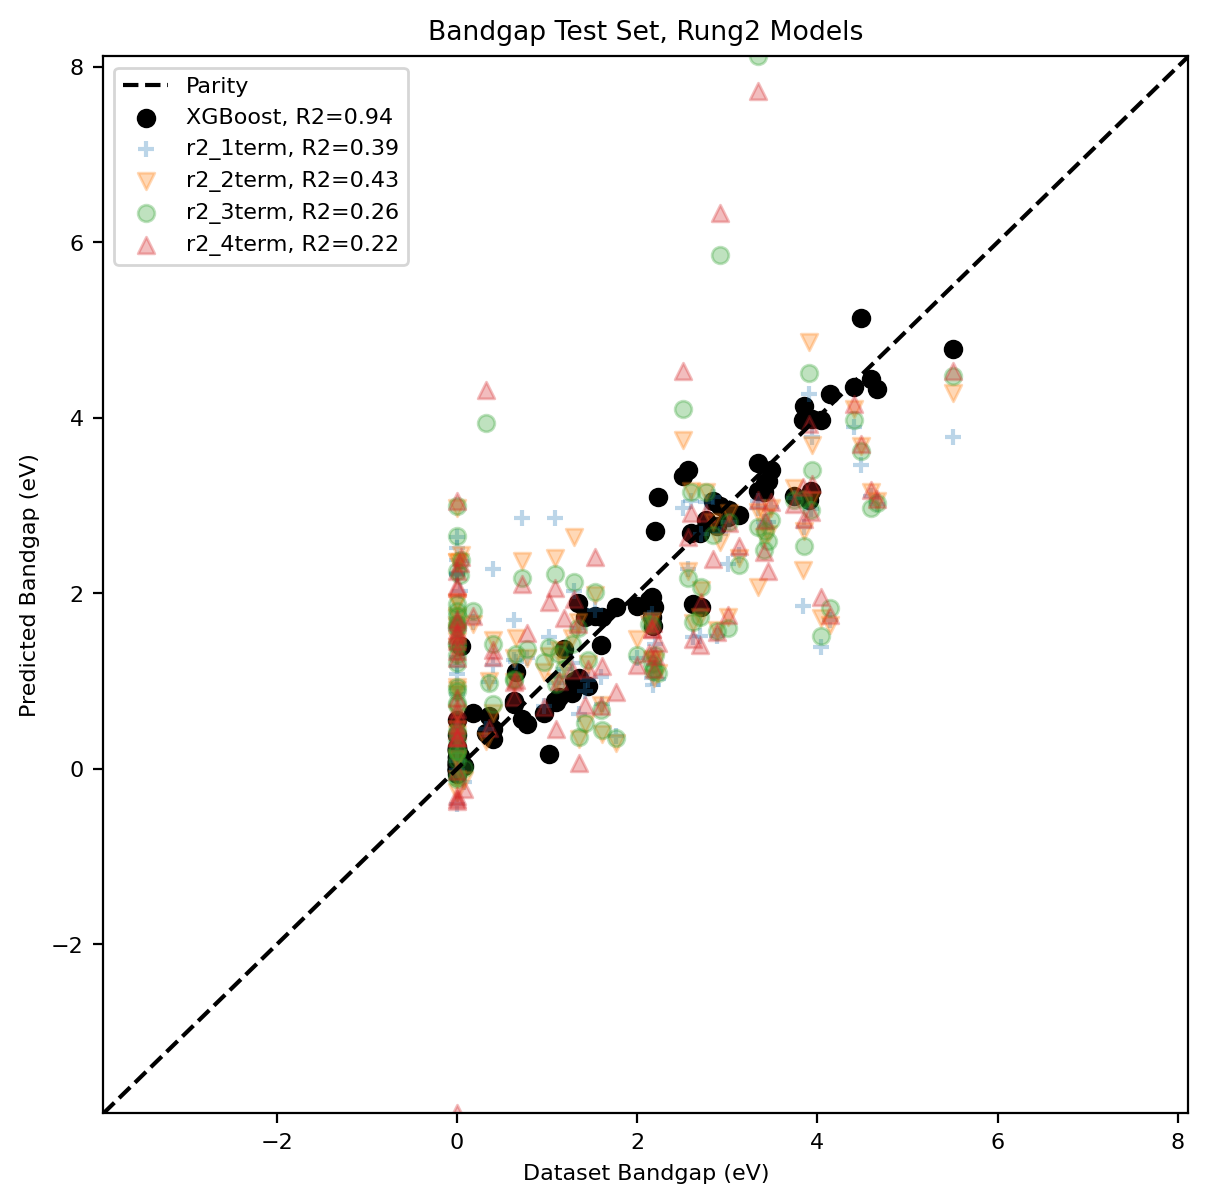

In [178]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=test[target], y_pred=best_regression.predict(test_x_regression)), 2)

plt.scatter(x=test['bandgap (eV)'], y=best_regression.predict(test_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r2_1term', 'r2_2term', 'r2_3term', 'r2_4term']:
    plt.scatter(x=test['bandgap (eV)'], y=test[model_label], label=f"{model_label}, R2={get_r2(model_label, test)}", alpha=0.3, marker=next(markers))
plt.plot([test_min, test_max], [test_min, test_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([test_min, test_max])
plt.ylim([test_min, test_max])

plt.title('Bandgap Test Set, Rung2 Models')
plt.ylabel('Predicted Bandgap (eV)')
plt.xlabel('Dataset Bandgap (eV)')
plt.legend()